In [1]:
# Final version of the water-filling in 1dspace-time.

# This is just 1D time. IS there a benefit of having two cell types in this scenario

In [2]:
import numpy as np
import matplotlib.pyplot as plt

%matplotlib inline

In [3]:
# parameters


NFREQ = 100 # discretization
f1 = 1e-6 # lowest freq
f2 = 1e0 # highest freq


## equilibrated trapezoid
N = 1 # noise level



In [5]:
# Generate spectrum

X = np.exp(np.linspace(np.log(f1),np.log(f2),NFREQ))
T = np.exp(np.linspace(np.log(f1),np.log(f2),NFREQ))


# Power density
Sdensity = 1/(X[:-1]**2)
S = np.diff(-1/X)

print(S.shape)

# Total Power
total_S = np.sum(S)

print(total_S)

(99,)
999999.0


In [13]:
## Compute water filling for a range of lambdas

# range of lambdas
NLAMBDAS = 100
lambdas = np.logspace(0,12,NLAMBDAS)

# library of water-filling solutions for different lamdas
Ws = list()
for lambd in lambdas:
    F = np.sqrt(N/(lambd*Sdensity)) - N/Sdensity #Filter Magnitue Square per mode
    W = S*F #Total water per block
    W[W<0] = 0 
    
    #plt.figure()
    #plt.imshow(np.sqrt(W), cmap = 'seismic', vmin = -np.max(np.sqrt(W)), vmax =  np.max(np.sqrt(W)),origin='lower')
    #plt.colorbar()
    
    Ws.append(W.T)

Ws = np.array(Ws).T
Ws.shape


(99, 100)

In [14]:
# Sum across temporal frequencies (we don't need those)

# volume of each voxel
Nf = np.diff(X)

# Precompute variance per mode explained for all lambdas
colVarExpl = S[:,np.newaxis]*Ws/(Ws+N*Nf[:,np.newaxis])
# cumulative variance explained (it's going to fasten up things in the grid search)
cumVarExpl = np.vstack((np.zeros(NLAMBDAS),np.cumsum(colVarExpl,axis = 0)))

# Water filling array for all modes and lamdas
colWs = Ws
# Cumulative Water filling array (it's going to fasten up things in the grid search)
cumWs = np.vstack((np.zeros(NLAMBDAS),np.cumsum(colWs,axis = 0)))

print(colVarExpl.shape, cumVarExpl.shape,colWs.shape, cumWs.shape)

(99, 100) (100, 100) (99, 100) (100, 100)


In [24]:
## Iterate over all possible decompositions between N cell types to find the best one

RECS = list()
STRS = list()

# Number of types
for NTYPES in range(1,3):

    ## Create grid for grid search

    # Create grid for grid search over strides for different types
    STEP = 1 # step of the grid search
    strides = np.arange(0,NFREQ,STEP)
    NSTRIDES = len(strides)
    g = [strides for i in range(NTYPES)]
    g = np.meshgrid(*g)
    stride_grid = np.array([gi.ravel() for gi in g])

    # Create grid for grid serach over lambdas to find best objective
    g = [np.arange(0,NLAMBDAS) for i in range(NTYPES)]
    g = np.meshgrid(*g)
    lambda_grid = np.array([gi.flatten() for gi in g])

    print(stride_grid.shape,lambda_grid.shape)

    recs = list()
    strides = list()

    # Total firing rate threshold ('number of spikes')
    for NSPIKES in np.logspace(-4,-1,20):
        #print(NSPIKES)

        GRID = np.zeros(NTYPES)
        NITER =  stride_grid.shape[1]

        EXPL = np.zeros(NITER)
        OBJ = np.zeros(NITER)
        LAMB = np.zeros((NITER,NTYPES))
        
        # start grid search over strides of each type
        for i in range(NITER):
            lims = stride_grid[:,i] # end limit of the modes covered by each type

            if np.all(np.diff(lims)>0) and lims[0]>0: # if all limits are in an 
                #increasing order (avoid switching types) 


                lims2 = [0,*lims]
                
                #print(lims)

                all_varsExpl = list()
                all_l1s = list()
                for typ in range(NTYPES):

                    # Variance explained for each lambda
                    varExp = cumVarExpl[lims2[typ+1]] - cumVarExpl[lims2[typ]]

                    # Budget of cells for each type
                    budgetCells = X[lims2[typ+1]] - X[lims2[typ]]

                    # penalty
                    l1_penalty = np.sqrt(budgetCells*(cumWs[lims2[typ+1]]- cumWs[lims2[typ]]))

                      
                    all_varsExpl.append(varExp)
                    all_l1s.append(l1_penalty)


                all_varsExpl = np.array(all_varsExpl)
                total_varsExpl = sum([all_varsExpl[ityp,lambda_grid[ityp]] for ityp in range(NTYPES)])
                
                all_l1s = np.array(all_l1s)
                total_l1s = sum([all_l1s[ityp,lambda_grid[ityp]] for ityp in range(NTYPES)])
                
                # objective for each lambda
                objective = total_varsExpl - 1e60 * np.maximum(total_l1s - NSPIKES, 0)   

                best_lambdas_ind = np.argmax(objective)
                
                best_lambdas = lambda_grid[:,best_lambdas_ind]
                

                #if 0 in best_lambdas:
                #    print('warning lambda LOWER bound reached',lims)
                #if NLAMBDAS-1 in best_lambdas:
                #    print('warning lambda UPPER bound reached')

                best_objective = objective[best_lambdas_ind]

                best_varExp = total_varsExpl[best_lambdas_ind]

                EXPL[i] = best_varExp
                LAMB[i,:] = best_lambdas        
                OBJ[i] = best_objective
                
                #print(best_objective)
                #print(best_varExp)
                
                #STRIDES[i,:] = best_strides

                #print(lims,best_lambdas,best_objective)

                #print(sumObjs.shape,lambda_grid.shape)
                
        
        iter_max = np.argmax(OBJ)
        
        rec = (np.sum(S) - EXPL[iter_max])/np.sum(S)*100
        st = stride_grid[:,iter_max]

        recs.append(rec)
        strides.append(st)
        #print(np.argmax(EXPL))
        print('RECONSTRUCTION ERROR: ',rec,'%')
        print('BEST NCELLS:', stride_grid[:,iter_max])
        print('BEST LAMBDAS:', LAMB[iter_max])
        print('OBJ:', OBJ[iter_max])
        print('')
        
    RECS.append(recs)
    STRS.append(strides)

(1, 100) (1, 100)
RECONSTRUCTION ERROR:  6.51683228526 %
BEST NCELLS: [22]
BEST LAMBDAS: [ 62.]
OBJ: 934830.742316

RECONSTRUCTION ERROR:  4.8663997045 %
BEST NCELLS: [26]
BEST LAMBDAS: [ 62.]
OBJ: 951335.051619

RECONSTRUCTION ERROR:  3.76050802069 %
BEST NCELLS: [26]
BEST LAMBDAS: [ 57.]
OBJ: 962393.957398

RECONSTRUCTION ERROR:  2.79158567189 %
BEST NCELLS: [30]
BEST LAMBDAS: [ 57.]
OBJ: 972083.171197

RECONSTRUCTION ERROR:  2.07550600299 %
BEST NCELLS: [31]
BEST LAMBDAS: [ 53.]
OBJ: 979243.960725

RECONSTRUCTION ERROR:  1.58800047391 %
BEST NCELLS: [34]
BEST LAMBDAS: [ 52.]
OBJ: 984119.011141

RECONSTRUCTION ERROR:  1.15867695392 %
BEST NCELLS: [36]
BEST LAMBDAS: [ 49.]
OBJ: 988412.242048

RECONSTRUCTION ERROR:  0.8431191796 %
BEST NCELLS: [39]
BEST LAMBDAS: [ 47.]
OBJ: 991567.816635

RECONSTRUCTION ERROR:  0.617581801262 %
BEST NCELLS: [40]
BEST LAMBDAS: [ 43.]
OBJ: 993823.188163

RECONSTRUCTION ERROR:  0.47297685072 %
BEST NCELLS: [43]
BEST LAMBDAS: [ 42.]
OBJ: 995269.236223

REC

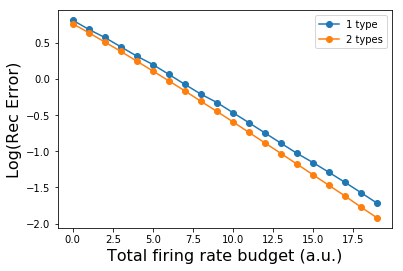

In [25]:
# Reconstruction error wrt spike budgets for different number of types


plt.plot(np.log(np.array(RECS).T)/np.log(10),'-o')
plt.xlabel('Total firing rate budget (a.u.)',fontsize = 16)
plt.ylabel('Log(Rec Error)',fontsize = 16)
#plt.yticks([-1,-2,-3])
plt.legend(['1 type','2 types','3 types'])

#plt.savefig('performance.eps')

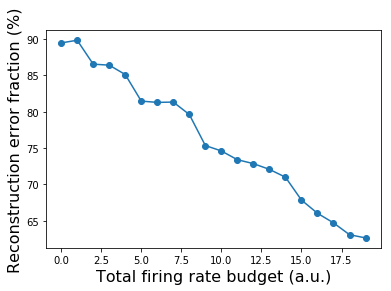

In [28]:
# Ratio of reconstruction error between one type and two types

r = np.array(RECS)
plt.plot(100*r[1]/r[0],'-o')
plt.xlabel('Total firing rate budget (a.u.)',fontsize = 16)
plt.ylabel('Reconstruction error fraction (%)',fontsize = 16)
#plt.legend(['1 type','2 types','3 types'])

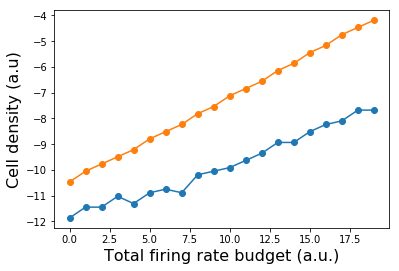

In [27]:
# plot evolution of density with budget

plt.plot(np.log(X[np.array(STRS[1])]),'-o')
#plt.plot(1/np.array(STRS[2]),'-o')
plt.ylabel('Cell density (a.u)',fontsize = 16)
plt.xlabel('Total firing rate budget (a.u.)',fontsize = 16)


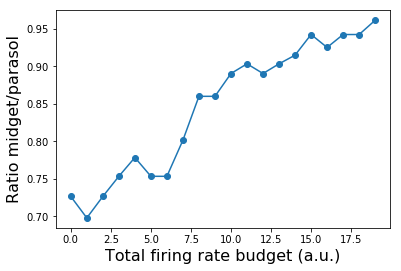

In [23]:
plt.plot(X[np.array(STRS[1])][:,1]/(X[np.array(STRS[1])][:,0]+X[np.array(STRS[1])][:,1]),'-o')
plt.ylabel('Ratio midget/parasol',fontsize = 16)
plt.xlabel('Total firing rate budget (a.u.)',fontsize = 16)

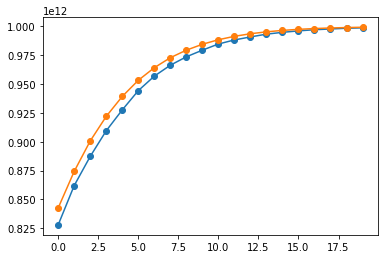

In [287]:
plt.plot(-(np.array(RECS).T/100*np.sum(S)-np.sum(S)),'-o')